In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
import tensorflow as tf

In [2]:
np.random.seed(0)

In [3]:
def converter(x):
    if x == 2:
        return [1, 0]
    else:
        return [0, 1]
    
vconverter = np.vectorize(converter)

data = np.genfromtxt("breast-cancer.data", delimiter=",", missing_values="?", filling_values=1.)

dataX = data[:, 1:-1]
pre_dataY = data[:, -1]
dataY = np.zeros((pre_dataY.size, 2))

for i in range(len(pre_dataY)):
    if pre_dataY[i] == 2:
        dataY[i][0] = 1
    else:
        dataY[i][1] = 1

In [4]:
permutation = np.random.permutation(dataX.shape[0])
dataX = dataX[permutation]
dataY = dataY[permutation]

In [5]:
nIn = 9
nHidden = 25
nOut = 2
alpha = 0.01
nEpochs = 100
testSplit = 0.15
batchSize = 64

In [6]:
X = tf.placeholder(shape=[None, nIn], dtype=tf.float32)
Y = tf.placeholder(shape=[None, nOut], dtype=tf.float32)

In [7]:
def nn_forward(X, weights, biases):
    
    layer2 = tf.nn.bias_add(tf.matmul(X, weights["W1"]), biases["b1"])
    layer2 = tf.nn.sigmoid(layer2)
    
    out = tf.nn.bias_add(tf.matmul(layer2, weights["W2"]), biases["b2"])
    out = tf.nn.sigmoid(out)
    
    return out

In [8]:
weights = {"W1": tf.Variable(tf.random_normal([nIn, nHidden]) * 0.5),
           "W2": tf.Variable(tf.random_normal([nHidden, nOut]) * 0.5)}

biases = {"b1": tf.Variable(tf.zeros([nHidden])),
           "b2": tf.Variable(tf.zeros([nOut]))}

In [9]:
pred = nn_forward(X, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, axis=1), tf.argmax(Y, axis=1)), tf.float32))

In [10]:
sess = tf.Session()

In [11]:
def testAccuracy():
    correct = 0
    total = int(testSplit * len(dataX))

    for i in range(total):
        index = len(dataX) - int(testSplit * len(dataX)) + i
        acc = sess.run(accuracy, feed_dict={X: dataX[index].reshape(-1, nIn), Y: dataY[index].reshape(-1, nOut)})
        correct += acc

    return correct/total

Epoch 0 Loss: 0.5742526054382324
	Accuracy: 0.0892436974789916
Epoch 10 Loss: 0.35857540369033813
	Accuracy: 0.9541176470588235
Epoch 20 Loss: 0.32294997572898865
	Accuracy: 0.9594957983193277
Epoch 30 Loss: 0.314834326505661
	Accuracy: 0.9601680672268907
Epoch 40 Loss: 0.31964346766471863
	Accuracy: 0.9670588235294117
Epoch 50 Loss: 0.315621554851532
	Accuracy: 0.9721008403361344
Epoch 60 Loss: 0.31449100375175476
	Accuracy: 0.9747899159663865
Epoch 70 Loss: 0.3199068605899811
	Accuracy: 0.9757983193277311
Epoch 80 Loss: 0.34842994809150696
	Accuracy: 0.9773109243697479
Epoch 90 Loss: 0.3473445475101471
	Accuracy: 0.9808403361344538


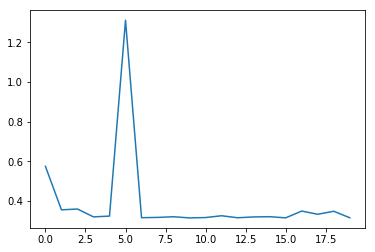

Final Accuracy: 0.9711538461538461


In [12]:
losses = []

#Using stochastic gradient descent
sess.run(tf.global_variables_initializer())

displayStride = 10

correct = 0
for j in range(nEpochs):
    nTraining = dataX.shape[0]-int(testSplit * len(dataX))
    for i in range(nTraining):
        loss, acc, _ = sess.run([cost, accuracy, optimizer], 
                                     feed_dict={X: dataX[i].reshape(-1, nIn), Y: dataY[i].reshape(-1, nOut)})
        correct += acc
    if j % displayStride == 0:
        acc = correct / (displayStride * nTraining)
        print("Epoch {} Loss: {}\n\tAccuracy: {}".format(j, loss, acc))
        correct = 0
        total = 0
    if j % 5 == 0:
        losses.append(loss)

plt.plot(losses)
plt.show()

print("Final Accuracy: {}".format(testAccuracy()))

Epoch 0 Loss: 0.6685041189193726
	Accuracy: 0.056638655452167286
Epoch 10 Loss: 0.3895722031593323
	Accuracy: 0.8596638660771506
Epoch 20 Loss: 0.34176403284072876
	Accuracy: 0.9573109243697479
Epoch 30 Loss: 0.330363929271698
	Accuracy: 0.9650420168067226
Epoch 40 Loss: 0.32535892724990845
	Accuracy: 0.9709243697478992
Epoch 50 Loss: 0.32243120670318604
	Accuracy: 0.9761344537815126
Epoch 60 Loss: 0.32059812545776367
	Accuracy: 0.9788235294117648
Epoch 70 Loss: 0.31914591789245605
	Accuracy: 0.9815126050420168
Epoch 80 Loss: 0.31802254915237427
	Accuracy: 0.9828571428571429
Epoch 90 Loss: 0.31709831953048706
	Accuracy: 0.9831932773109243


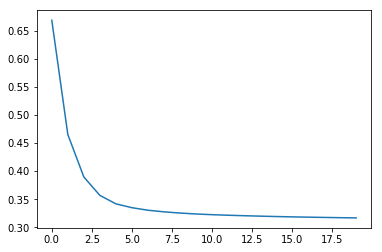

Final Accuracy: 0.9807692307692307


In [13]:
losses = []

#Using batch gradient descent
sess.run(tf.global_variables_initializer())

displayStride = 10

correct = 0
for j in range(nEpochs):
    nTraining = dataX.shape[0]-int(testSplit * len(dataX))
    for i in range(0, nTraining, batchSize):
        currBatchSize = min(batchSize, nTraining-i)
        loss, acc, _ = sess.run([cost, accuracy, optimizer], feed_dict={X: dataX[i:i+currBatchSize].reshape(-1, nIn), 
                                                         Y: dataY[i:i+currBatchSize].reshape(-1, nOut)})
        correct += acc * currBatchSize
    if j % displayStride == 0:
        acc = correct / (displayStride * nTraining)
        print("Epoch {} Loss: {}\n\tAccuracy: {}".format(j, loss, acc))
        correct = 0
        total = 0
    if j % 5 == 0:
        losses.append(loss)

plt.plot(losses)
plt.show()

print("Final Accuracy: {}".format(testAccuracy()))